### Dependencies
- exotk
- priors
- seaborn
- astropy
- george

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import datetime
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=1.2,rc={"font":"helvetica"});
sns.set_style("white"); #sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")

In [36]:
import getpass
# Remove gks paths (not needed for anyone else)
if getpass.getuser()=="gks":
    try:
        sys.path.remove("/Users/gks/Dropbox/mypylib/notebooks/GIT/transitMCMC/src")
        sys.path.remove("/Users/gks/Dropbox/mypylib")
    except Exception as e:
        print(e)
        print("Paths already removed")

list.remove(x): x not in list
Paths already removed


In [57]:
import astropy
import astropy.stats
from collections import OrderedDict
import priors
from priors import PriorSet, UP, NP, JP
import mcFunc
import batman
import gptransitfit
import george
print("Using george version:",george.__version__)
print("george version should be",'0.3.1.dev0')

Using george version: 0.3.1.dev0
george version should be 0.3.1.dev0


In [39]:
# Making sure that these are under "../src/"
print(gptransitfit.__file__)
print(priors.__file__)
print(mcFunc.__file__)

../src/gptransitfit.py
../src/priors.pyc
../src/mcFunc.py


In [54]:
class GPLPFunction(object):
    """
    An object to do a GP fit using George. Implements the Baysian Log probability function as a callable class.
    Use with 
    
    NOTES:
    - priorDict has to be in the same order as TransitModel
    """
    class TransitModel(george.modeling.Model):
        parameter_names = ("t0","p","i","k","a","baseline")
        u1 = 0.34024922
        u2 = 0.31559038 
        params = batman.TransitParams()
        #tm = pytransit.MandelAgol()
        def get_value(self, t):
            self.params.t0 = self.t0
            self.params.per = 10.**self.p
            self.params.inc = np.arccos(self.i)*180./np.pi
            self.params.rp = self.k
            self.params.a = 10.**self.a
            self.params.ecc = 0.
            self.params.w = 0.
            self.params.u = [self.u1,self.u2]
            self.params.limb_dark = "quadratic"
            self.params.fp = 0.001
            self.transitmodel = batman.TransitModel(self.params, t, transittype='primary')
            return self.transitmodel.light_curve(self.params)*self.baseline
            #return self.tm.evaluate(t,self.k,[self.u1,self.u2],self.t0,self.p,self.a,np.deg2rad(self.i))*self.baseline
    
    def __init__(self):
        """
        Add data and priors here
        """
        #df = pd.read_csv("/Users/gks/Box Sync/TRANSITS/k2_28b/17_32_48/Processed_K2-28b-diffuserin-30s_measurements.xls",sep="\t")
        df = pd.read_csv("../data/k2_28b/g_measurements.xls",sep="\t")
        df = df[0:-3]
        data = astropy.stats.sigma_clipping.sigma_clip(df.rel_flux_T1.values)
        m = data.mask
        self.x = df.HJD_UTC.values[~m]
        self.y = df.rel_flux_T1.values[~m]
        self.yerr = df.rel_flux_err_T1.values[~m]
        self.A = np.var(self.y) # Has to be positive, in kernel it takes log
        self.B = 10. # Has to be positive, in kernel it takes log
        self.priorDict = OrderedDict()
        self.priorDict["t0"]         = UP(2457931.90201-0.1  , 2457931.90201+0.1     ,"t0"      ,r"$T_C$")
        self.priorDict["logP"]       = NP(0.35419586574049089, 7.8772078002142587e-06,"logP"    ,r"$\log(P)$")
        self.priorDict["cos(i)"]     = NP(0.01919744239968964, 0.013960060871755579  ,"cos(i)"  ,r"$\cos(i)$")
        self.priorDict["RpRs"]       = UP(0.07370-0.01       , 0.07370+0.01          ,"RpRs"    ,r"$R_p/R_s$")
        self.priorDict["log(a/Rs)"]  = NP(1.2528530309798931 , 0.029114713870609061  ,"loga"    ,r"$\log(a/R_s)$")#UP(17.9-2.,17.9+2.,"a")
        self.priorDict["baseline"]   = UP(0.28588-0.01       , 0.28588+0.01          ,"baseline",r"baseline")
        #self.priorDict["whitenoise"]= UP(-10                , -5)
        self.priorDict["A"]          = UP(-20                ,1.                     ,"A"       ,r"$A$")
        self.priorDict["B"]          = UP(np.log(0.1)        ,5.                     ,"B"       ,r"$B$")
        self.ps = priors.PriorSet(self.priorDict.values())
        self.TM = self.TransitModel(*self.ps.centers[:-2]) # NOTE: HAS TO BE IN THE SAME ORDER AS TRANSIT MODEL EXPECTS
        self.gp = george.GP(self.A * george.kernels.ExpSquaredKernel(self.B),mean=self.TM,fit_mean=True,white_noise=np.log((np.diff(self.y).std()/np.sqrt(2))**2),fit_white_noise=False) 
        self.gp.compute(self.x,self.yerr)
    
    def lnprior(self,pv):
        """Log prior function"""
        return self.ps.c_log_prior(pv)
    
    def lnprob(self,pv):
        """Final log probability function"""
        self.gp.set_parameter_vector(pv)
        return self.gp.log_likelihood(self.y) + self.lnprior(pv)
        
    def neg_lnprob(self,pv):
        """Negative log probability function (for Nelder Mead optimization)"""
        return -1*self.lnprob(pv)
                
    def __call__(self,pv):
        """Call the lnprior function"""
        return self.lnprob(pv)

In [55]:
GG = gptransitfit.GPTransitFit(GPLPFunction)

In [56]:
GG.minimize_PyDE(mc_iter=2000)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
     labels       centers         lower         upper            pv   center_dist
0        t0  2.457932e+06  2.457932e+06  2.457932e+06  2.457932e+06  5.251999e-03
1      logP  3.541959e-01  3.541565e-01  3.542353e-01  3.541958e-01  2.383340e-08
2    cos(i)  1.919744e-02 -5.060286e-02  8.899775e-02  2.247334e-02 -3.275898e-03
3      RpRs  7.370000e-02  6.370000e-02  8.370000e-02  7.469317e-02 -9.931731e-04
4      loga  1.252853e+00  1.107279e+00  1.398427e+00  1.252024e+00  8.286164e-04
5  baseline  2.858800e-01  2.758800e-01  2.958800e-01  2.861992e-01 -3.192373e-04
6         A -9.500000e+00 -2.000000e+01  1.000000e+00 -1.999993e+01  1.049993e+01
7         B  1.348707e+00 -2.302585e+00  5.000000e+00  4.576143e+00 -3.227436e+00
('LogLn value:', -1481.3352082880915)
('Log priors', 21.175578225751067)
Running MCMC
Finished MCMC


#### Check chains to estimate burn in and chain mixing

Plotting chains


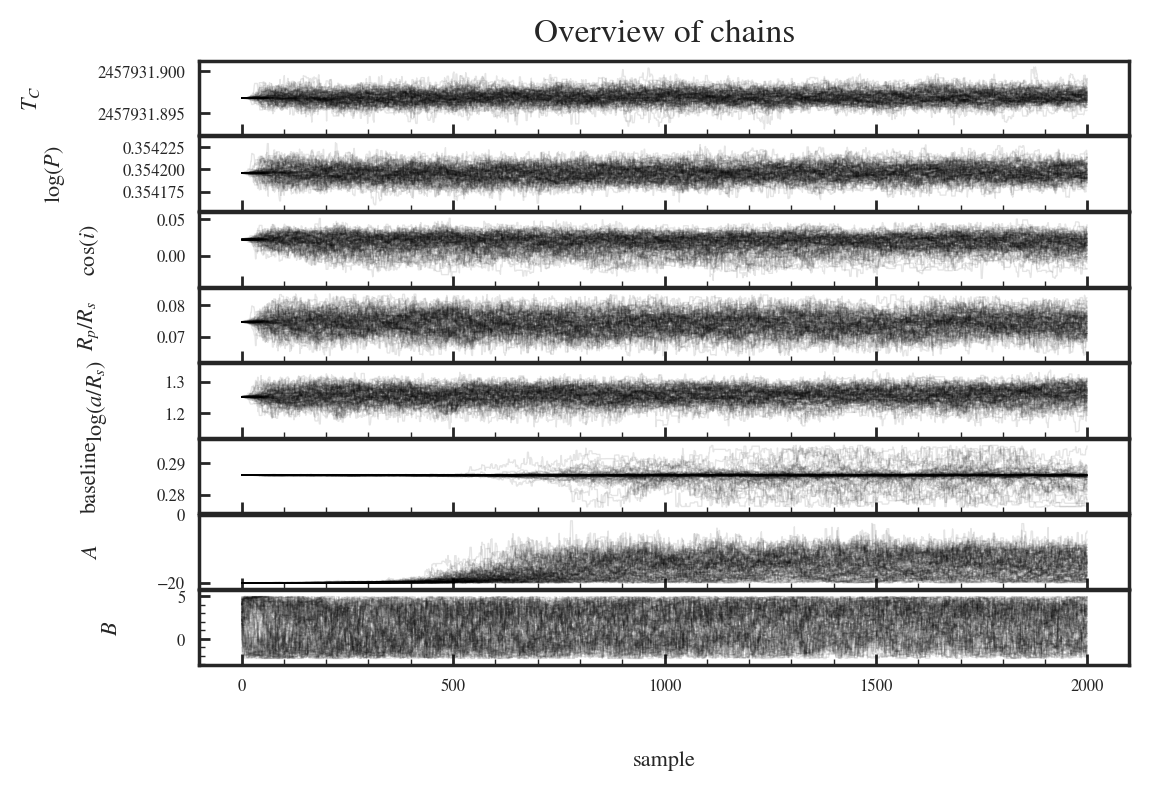

In [58]:
GG.plot_chains()

Plotting cornerplot


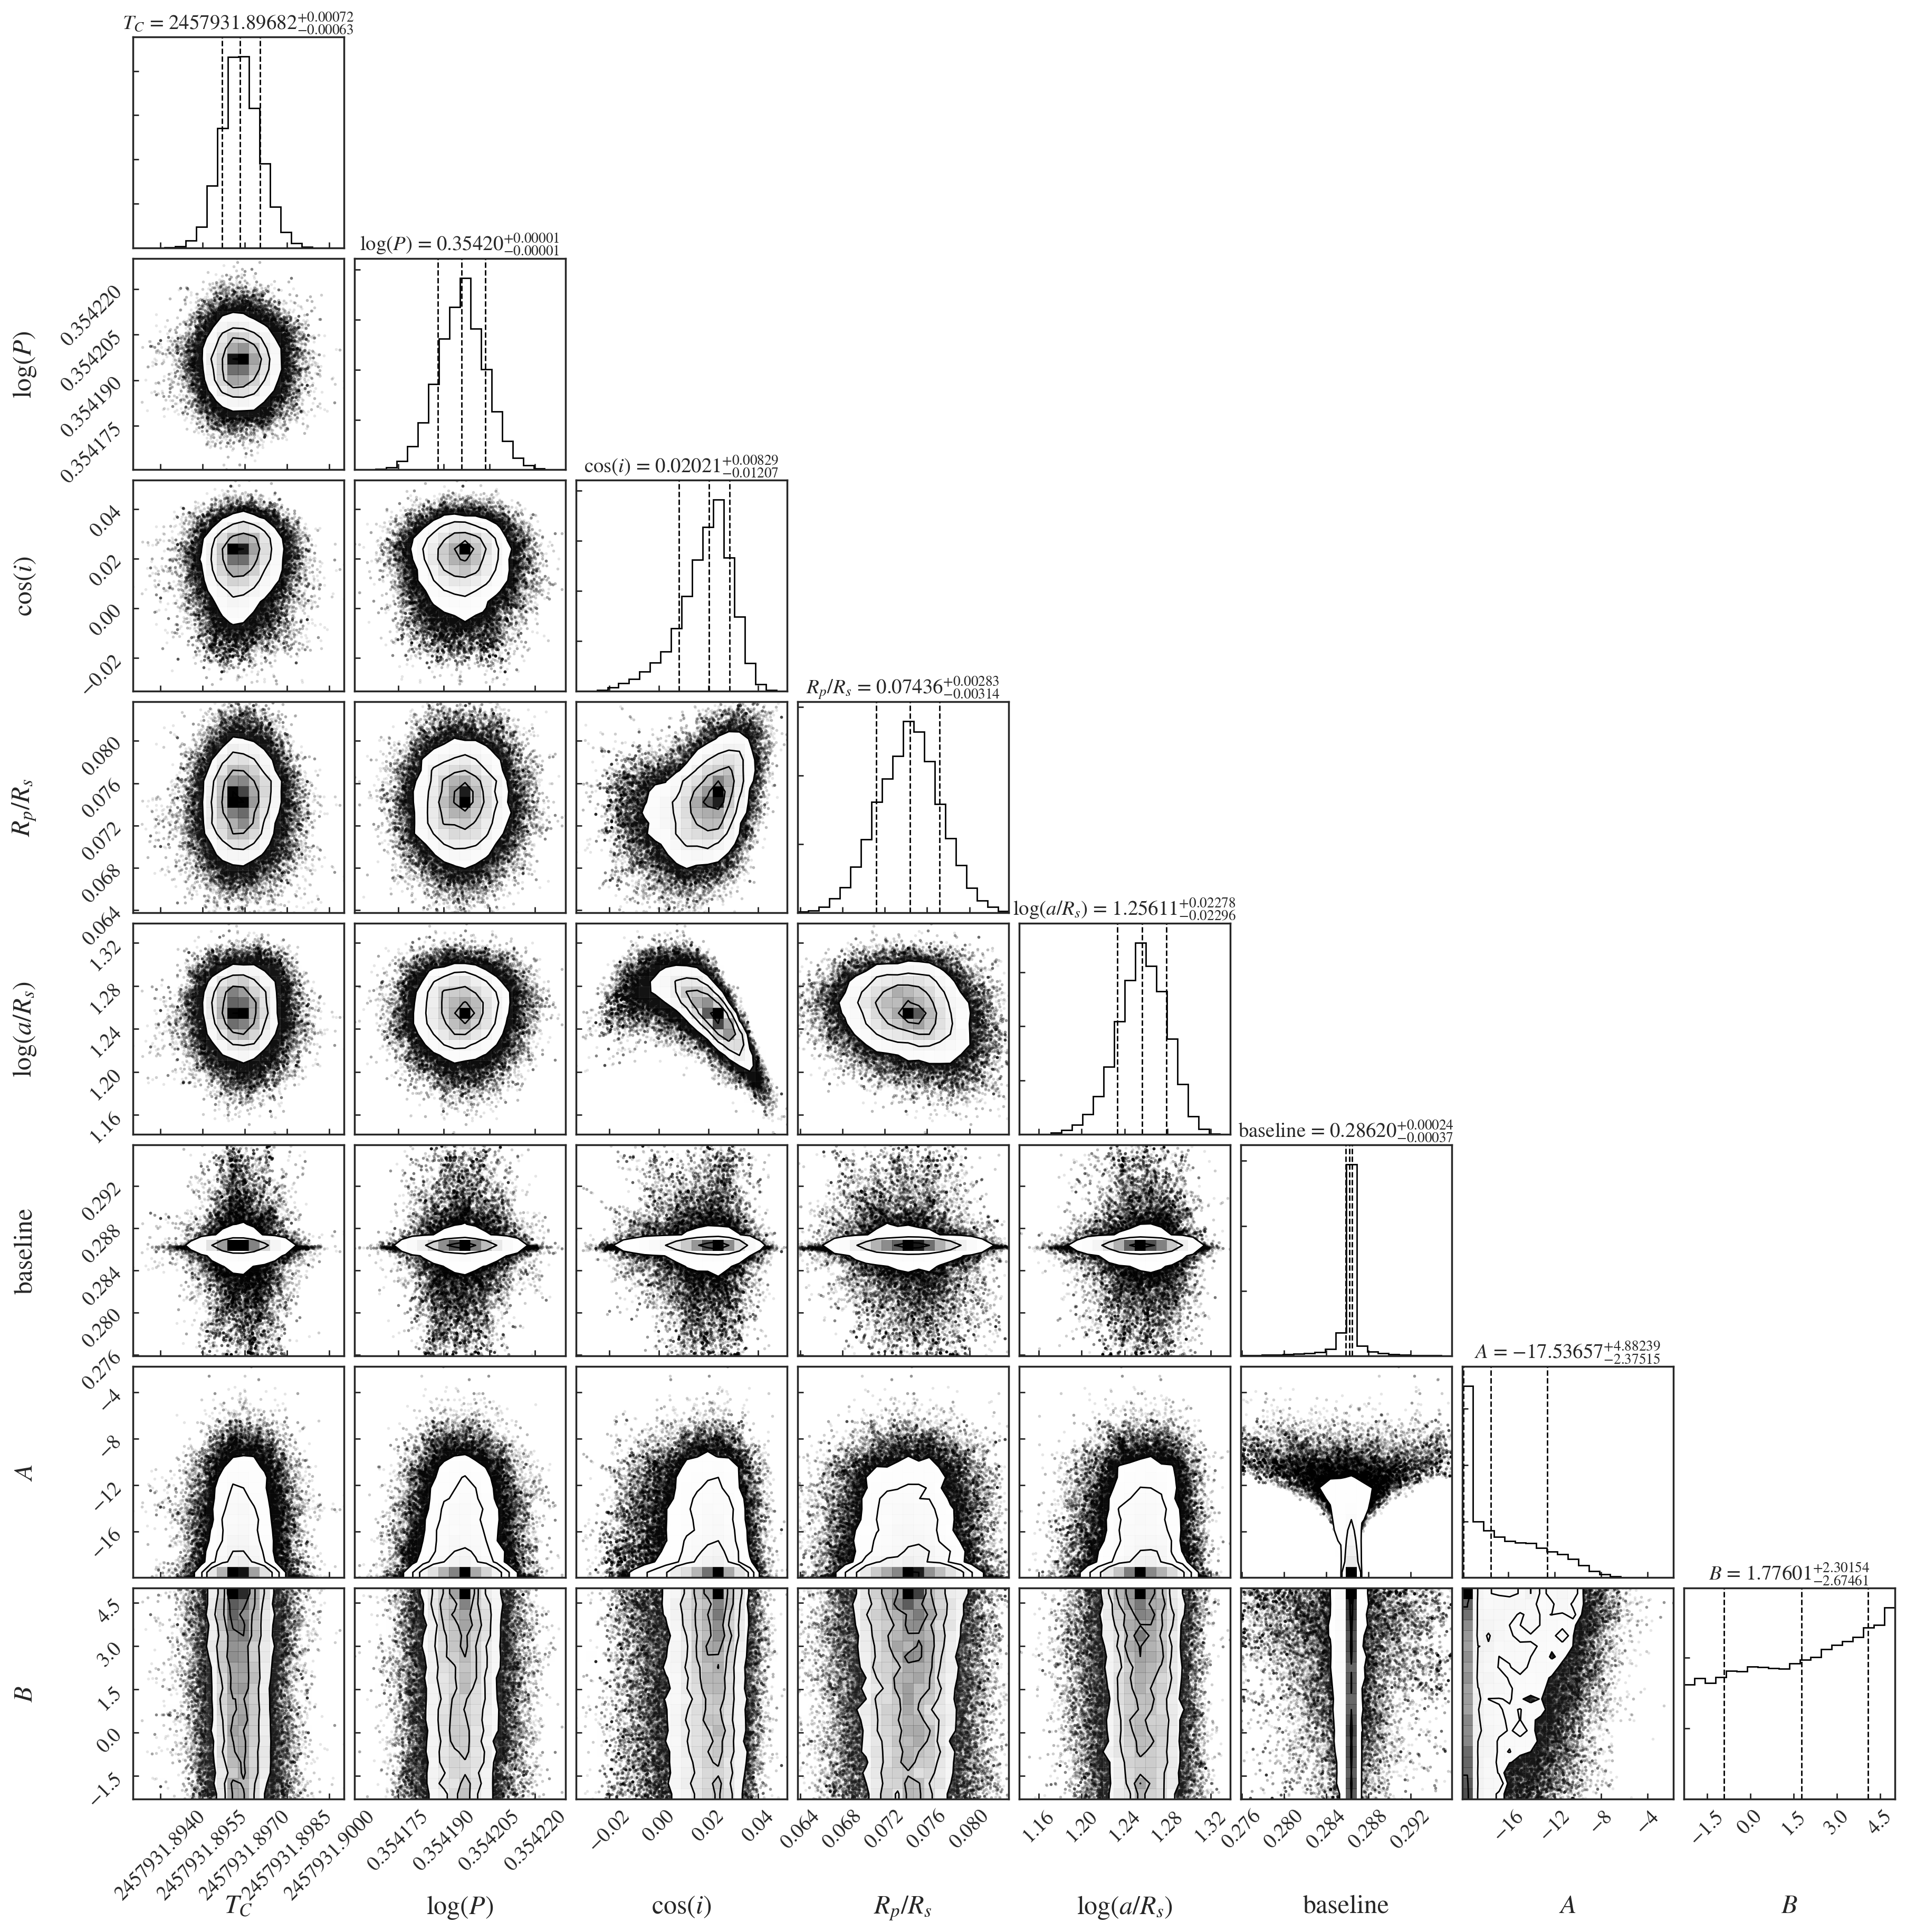

In [59]:
GG.plot_corner(burn=0,show_titles=True)

#### Only interesting parameters corner plot

Plotting cornerplot


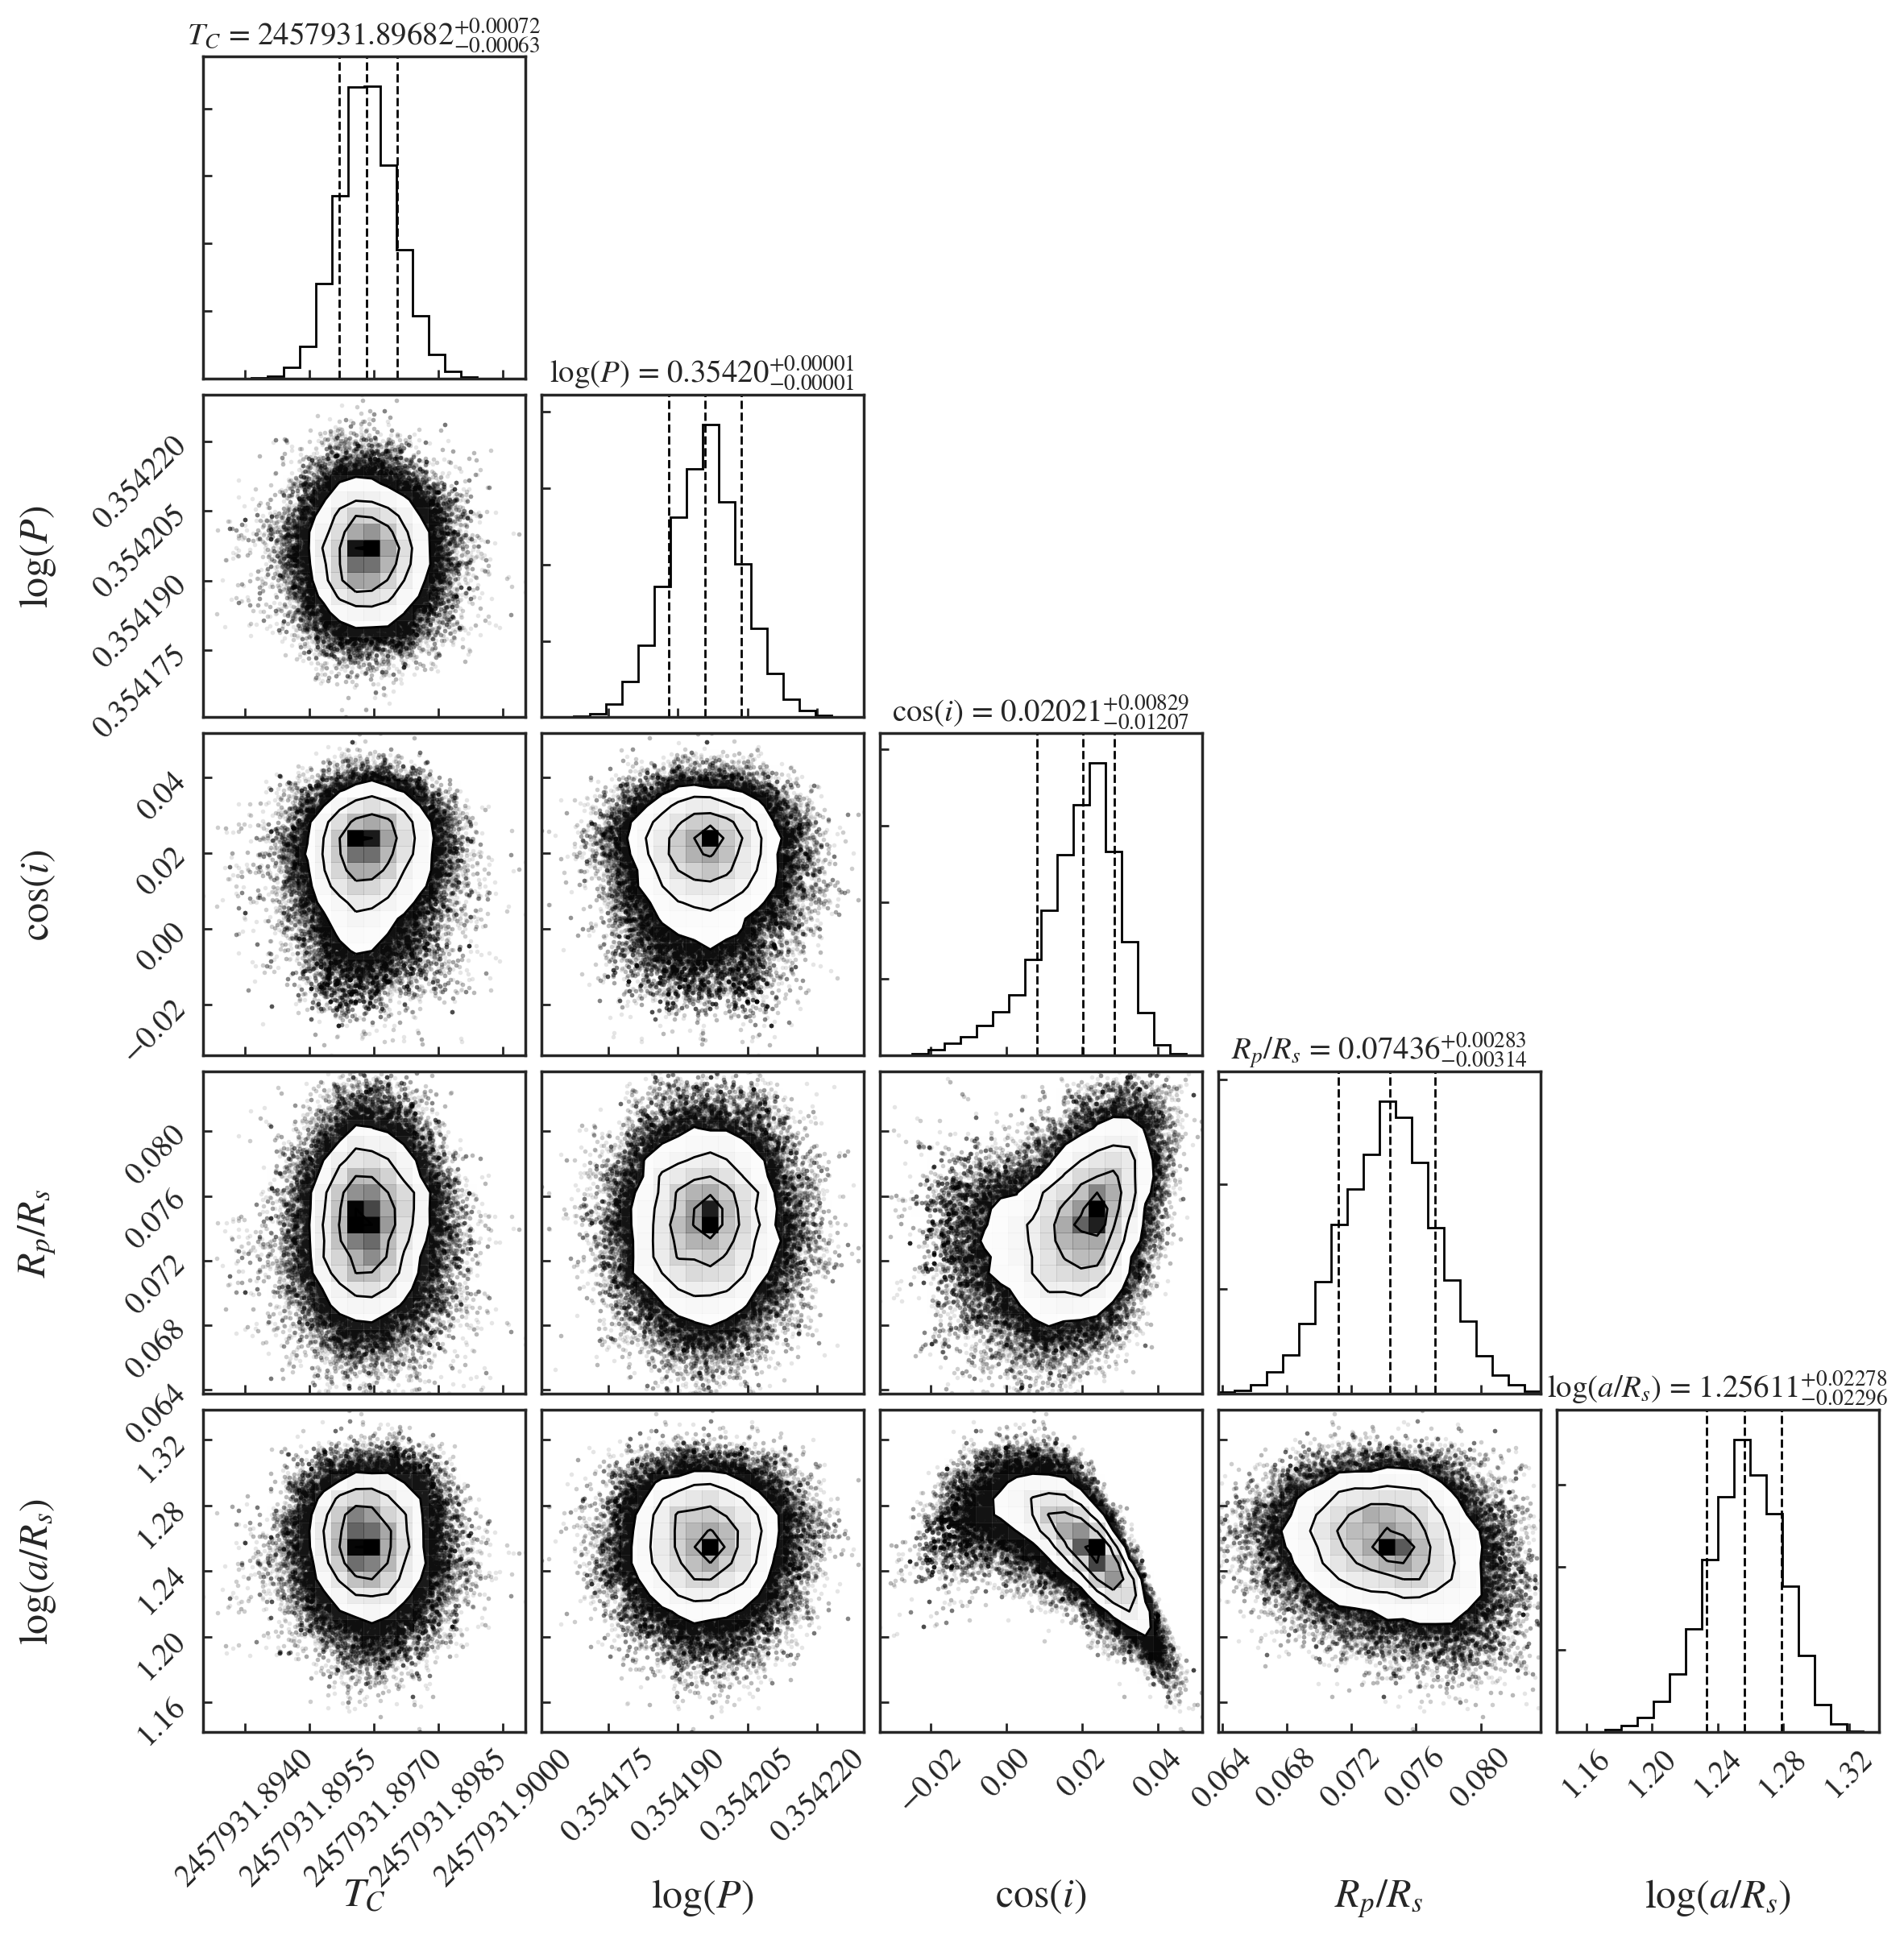

In [60]:
mcFunc.plot_corner(GG.sampler.chain[:,:,:5],labels=GG.lpf.ps.descriptions[:5],burn=0,title_fmt='.5f',show_titles=True)

#### Get transit parameters

In [62]:
df = GG.get_transit_parameters(st_rad=0.29,st_raderr1=0.03,st_teff=3214.,st_teff_err1=60.,burn=0)
df

Assuming
('R_s:', 0.29, '+-', 0.03)
('Teff:', 3214.0, '+-', 60.0)
16


medvals      minus       plus                                 values  \
0   2.457932e+06   0.000629   0.000719  $2457931.89682_{-0.00063}^{+0.00072}$   
1   2.260455e+00   0.000041   0.000040       $2.260455_{-0.00004}^{+0.00004}$   
2   7.435775e-02   0.003144   0.002828           $0.0744_{-0.0031}^{+0.0028}$   
3   2.345296e+00   0.256573   0.262240                 $2.35_{-0.26}^{+0.26}$   
4   2.092348e-01   0.022890   0.023396              $0.209_{-0.023}^{+0.023}$   
5   5.529074e-03   0.000458   0.000429        $0.00553_{-0.00046}^{+0.00043}$   
6   1.803470e+01   0.928588   0.971122                $18.03_{-0.93}^{+0.97}$   
7   2.428516e-02   0.002752   0.002856           $0.0243_{-0.0028}^{+0.0029}$   
8   8.884204e+01   0.475382   0.691516                $88.84_{-0.48}^{+0.69}$   
9   3.657753e-01   0.211796   0.127640                 $0.37_{-0.21}^{+0.13}$   
10  0.000000e+00   0.000000   0.000000                    $0.0_{-0.0}^{+0.0}$   
11  0.000000e+00   0.000000   0.000000                    $0.0_{-0.0}^{+0.0}$   
12  5.349225e+02  16.609062  17.793469                $535.0_{-17.0}^{+18.0}$   
13  4.016841e-02   0.001408   0.001390           $0.0402_{-0.0014}^{+0.0014}$   
14  3.177179e-03   0.000346   0.000462        $0.00318_{-0.00035}^{+0.00046}$   
15  2.457933e+06   0.000630   0.000717  $2457933.02704_{-0.00063}^{+0.00072}$   

                            Labels                Description  
0   $T_{0}$ $(\mathrm{BJD_{TDB}})$           Transit Midpoint  
1                       $P$ (days)             Orbital period  
2                        $R_p/R_*$               Radius ratio  
3                 $R_p (R_\oplus)$              Planet radius  
4                      $R_p (R_J)$              Planet radius  
5                         $\delta$              Transit depth  
6                          $a/R_*$  Normalized orbital radius  
7                         $a$ (AU)            Semi-major axis  
8                 $i$ $(^{\circ})$        Transit inclination  
9                              $b$           Impact parameter  
10                             $e$               Eccentricity  
11           $\omega$ $(^{\circ})$     Argument of periastron  
12            $T_{\mathrm{eq}}$(K)    Equilibrium temperature  
13                 $T_{14}$ (days)           Transit duration  
14                   $\tau$ (days)    Ingress/egress duration  
15  $T_{S}$ $(\mathrm{BJD_{TDB}})$  Time of secondary eclipse